In [1]:
# -*- coding: utf-8 -*-
"""
Cell 1 (Counterfactual Project): Environment Setup and Data Path Configuration
This cell mounts Google Drive and sets up paths to the GTEx raw data and project storage.
"""

# --- 1. Imports ---
import os
import pandas as pd
import numpy as np

# --- 2. Mount Google Drive ---
# This is crucial for accessing your pre-downloaded data and saving processed data.
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted.")

# --- 3. Define Project Root and Data Paths ---
# All project-related storage will be within this folder.
PROJECT_ROOT = '/content/drive/My Drive/Disentangling/'
RAW_DATA_DIR = os.path.join(PROJECT_ROOT, 'raw_data/')
PROCESSED_DATA_DIR = os.path.join(PROJECT_ROOT, 'processed_data_counterfactual/') # NEW: Dedicated folder for processed data for this project
ENCODERS_DIR = os.path.join(PROJECT_ROOT, 'encoders/') # NEW: Folder to save LabelEncoders/StandardScalers

# Ensure project and necessary sub-directories exist
os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(ENCODERS_DIR, exist_ok=True) # Create encoders directory

# Define full paths to your pre-downloaded GTEx raw files
TPM_FILE_PATH = os.path.join(RAW_DATA_DIR, "GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz")
SAMPLE_ATTRIBUTES_FILE_PATH = os.path.join(RAW_DATA_DIR, "GTEx_Analysis_2017-06-05_v8_Annotations_SampleAttributesDS.txt")
SUBJECT_PHENOTYPES_FILE_PATH = os.path.join(RAW_DATA_DIR, "GTEx_Analysis_2017-06-05_v8_Annotations_SubjectPhenotypesDS.txt")


# --- 4. Verify Pre-Downloaded Files ---
print("Verifying presence of pre-downloaded GTEx raw files:")

if os.path.exists(TPM_FILE_PATH):
    print(f"Gene Expression (TPM) file found: {TPM_FILE_PATH}")
else:
    raise FileNotFoundError(f"Gene Expression (TPM) file NOT found at: {TPM_FILE_PATH}. Please ensure it's there.")

if os.path.exists(SAMPLE_ATTRIBUTES_FILE_PATH):
    print(f"Sample Attributes file found: {SAMPLE_ATTRIBUTES_FILE_PATH}")
else:
    raise FileNotFoundError(f"Sample Attributes file NOT found at: {SAMPLE_ATTRIBUTES_FILE_PATH}. Please ensure it's there.")

if os.path.exists(SUBJECT_PHENOTYPES_FILE_PATH):
    print(f"Subject Phenotypes file found: {SUBJECT_PHENOTYPES_FILE_PATH}")
else:
    print("\n--- ACTION REQUIRED ---")
    print(f"Subject Phenotypes file NOT found at: {SUBJECT_PHENOTYPES_FILE_PATH}.")
    print("Please download it from: https://storage.googleapis.com/gtex_analysis_v8_data/annotations/GTEx_Analysis_2017-06-05_v8_Annotations_SubjectPhenotypesDS.txt")
    print(f"And place it into your '{RAW_DATA_DIR}' folder.")
    raise FileNotFoundError("Subject Phenotypes file missing. Cannot proceed without it.")


print("\nCell 1 execution complete. Paths configured and all required raw files verified.")
print(f"Processed data will be saved to: {PROCESSED_DATA_DIR}")
print(f"Encoders will be saved to: {ENCODERS_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted.
Verifying presence of pre-downloaded GTEx raw files:
Gene Expression (TPM) file found: /content/drive/My Drive/Disentangling/raw_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz
Sample Attributes file found: /content/drive/My Drive/Disentangling/raw_data/GTEx_Analysis_2017-06-05_v8_Annotations_SampleAttributesDS.txt
Subject Phenotypes file found: /content/drive/My Drive/Disentangling/raw_data/GTEx_Analysis_2017-06-05_v8_Annotations_SubjectPhenotypesDS.txt

Cell 1 execution complete. Paths configured and all required raw files verified.
Processed data will be saved to: /content/drive/My Drive/Disentangling/processed_data_counterfactual/
Encoders will be saved to: /content/drive/My Drive/Disentangling/encoders/


In [3]:
# -*- coding: utf-8 -*-
"""
Cell 2 (Counterfactual Project): Optimized Loading, Merging, and Aggressive Subsetting
Loads and merges GTEx metadata, performs memory-optimized gene expression data processing,
and saves processed data and fitted encoders/scalers.
FIXED: NameError for individual_encoder by making it global.
"""

# --- 1. Imports ---
import pandas as pd
import numpy as np
import os
import gzip
import pickle # For saving/loading sklearn objects
from tqdm.notebook import tqdm
import gc # For explicit garbage collection
from sklearn.preprocessing import LabelEncoder, StandardScaler # For data prep

# Ensure all necessary paths are defined from Cell 1
try:
    print(f"Project root: {PROJECT_ROOT}")
    print(f"Raw data dir: {RAW_DATA_DIR}")
    print(f"TPM file path: {TPM_FILE_PATH}")
    print(f"Sample Attributes file path: {SAMPLE_ATTRIBUTES_FILE_PATH}")
    print(f"Subject Phenotypes file path: {SUBJECT_PHENOTYPES_FILE_PATH}")
    print(f"Processed data dir: {PROCESSED_DATA_DIR}")
    print(f"Encoders dir: {ENCODERS_DIR}")
except NameError:
    print("Please run Cell 1 first to define necessary paths.")
    exit()

# --- 2. Define Subsetting Parameters (CRUCIAL FOR COLAB FEASIBILITY) ---
TARGET_TISSUE_TYPES = [
    "Lung", "Heart - Left Ventricle", "Liver", "Skeletal Muscle",
    "Adipose - Subcutaneous", "Brain - Cortex", "Skin - Not Sun Exposed (Suprapubic)",
    "Whole Blood", "Kidney - Cortex", "Pancreas", "Thyroid", "Ovary", "Testis", "Adrenal Gland",
    "Artery - Tibial", "Esophagus - Muscularis", "Spleen"
]

NUM_HIGHLY_VARIABLE_GENES = 2000
MIN_TPM_THRESHOLD = 0.5
MIN_SAMPLES_EXPRESSED_PERCENT = 0.1

# --- 3. Load and Merge Metadata Files ---
print("\n--- Step 3: Loading and Merging GTEx Metadata Files ---")

# Load Sample Attributes (sample-level metadata)
sample_attrs_df = pd.read_csv(SAMPLE_ATTRIBUTES_FILE_PATH, sep='\t', header=0)
print(f"Loaded {len(sample_attrs_df)} samples from Sample Attributes file.")

# Extract 'SUBJID' from 'SAMPID' in sample_attrs_df for merging
sample_attrs_df['SUBJID_Extracted'] = sample_attrs_df['SAMPID'].apply(lambda x: '-'.join(x.split('-')[:2]))

# Load Subject Phenotypes (donor-level metadata: AGE, SEX)
subject_pheno_df = pd.read_csv(SUBJECT_PHENOTYPES_FILE_PATH, sep='\t', header=0)
print(f"Loaded {len(subject_pheno_df)} subjects from Subject Phenotypes file.")

# Merge the two metadata DataFrames on 'SUBJID'
metadata_full_df = pd.merge(sample_attrs_df, subject_pheno_df[['SUBJID', 'AGE', 'SEX']],
                            left_on='SUBJID_Extracted', right_on='SUBJID', how='left')
metadata_full_df.drop(columns=['SUBJID_Extracted'], inplace=True)

print(f"Total samples after initial metadata merge: {len(metadata_full_df)}")

# Filter for relevant sample types and quality metrics
metadata_filtered_df = metadata_full_df[
    metadata_full_df['SMTSD'].isin(TARGET_TISSUE_TYPES) &
    (metadata_full_df['SMRIN'].notna()) &
    (metadata_full_df['AGE'].notna()) &
    (metadata_full_df['SEX'].notna())
].copy()

# Select relevant columns and rename for clarity
metadata_final_df = metadata_filtered_df[[
    'SAMPID', 'SUBJID', 'SMTSD', 'AGE', 'SEX', 'SMRIN'
]].copy()
metadata_final_df.rename(columns={
    'SAMPID': 'sample_id', 'SUBJID': 'individual_id', 'SMTSD': 'tissue_type',
    'AGE': 'age_group', 'SEX': 'sex', 'SMRIN': 'rna_integrity_number'
}, inplace=True)

# Process age_group to a numerical representation
def parse_age_group(age_str):
    if pd.isna(age_str): return np.nan
    try:
        age_str = str(age_str).strip()
        if '+' in age_str:
            return float(age_str.replace('+', '')) + 5
        elif '-' in age_str:
            parts = age_str.split('-')
            return (float(parts[0]) + float(parts[1])) / 2
        return np.nan
    except ValueError:
        return np.nan

metadata_final_df['age_numerical'] = metadata_final_df['age_group'].apply(parse_age_group)

# Final dropna after age parsing
metadata_final_df.dropna(subset=['age_numerical', 'sex', 'tissue_type'], inplace=True)

print(f"Filtered samples based on tissue types, quality, and complete metadata: {len(metadata_final_df)}")
print(f"Selected tissue types: {TARGET_TISSUE_TYPES}")

# Clear original large metadata DFs to free memory early
del metadata_full_df, metadata_filtered_df, sample_attrs_df, subject_pheno_df
gc.collect()

print("\n--- metadata_final_df.info() (after initial filtering) ---")
metadata_final_df.info()
print("--- End metadata_final_df.info() ---")


# --- 4. Gene Expression Data (TPM) - Optimized Two-Pass Strategy ---
print("\n--- Step 4: Optimized Two-Pass Loading and Subsetting of Gene Expression Data (TPM) ---")

# --- Get GCT File Header Sample IDs ---
print("Reading GCT file header to get all sample IDs...")
with gzip.open(TPM_FILE_PATH, 'rt') as f:
    _ = f.readline() # Skip "#1.2"
    _ = f.readline() # Skip dimensions line
    header_line = f.readline().strip()
    full_gct_sample_ids = [s.split('.')[0] for s in header_line.split('\t')[2:]]

# --- CRITICAL ALIGNMENT STEP: Identify samples common to both metadata AND GCT header ---
metadata_samples = set(metadata_final_df['sample_id'].tolist())
gct_samples = set(full_gct_sample_ids)

common_and_filtered_samples = sorted(list(metadata_samples.intersection(gct_samples)))

print(f"Total samples in metadata after initial filter: {len(metadata_final_df)}")
print(f"Total samples in GCT file header: {len(full_gct_sample_ids)}")
print(f"Samples common to both metadata and GCT file: {len(common_and_filtered_samples)}")

# Update metadata_final_df to only include these common samples, and sort by them for consistency
metadata_final_df = metadata_final_df[metadata_final_df['sample_id'].isin(common_and_filtered_samples)].copy()
metadata_final_df.set_index('sample_id', inplace=True)
metadata_final_df = metadata_final_df.loc[common_and_filtered_samples].reset_index()
target_sample_ids = metadata_final_df['sample_id'].tolist()

# Create a mapping from GCT sample ID (cleaned) to its column index in the GCT file's data part
gct_sample_id_to_col_idx = {sid: i for i, sid in enumerate(full_gct_sample_ids)}

gct_col_indices_for_extraction = [gct_sample_id_to_col_idx[sid] for sid in target_sample_ids]

print(f"Updated metadata_final_df has {len(metadata_final_df)} samples, matching GCT common samples.")


# --- Pass 1: Determine Top Variable Genes (Memory Efficient) ---
print("Pass 1: Identifying top variable genes across selected samples (memory efficient)...")

gene_variabilities = []
gene_expressed_counts = []
gene_ids_all = []

with gzip.open(TPM_FILE_PATH, 'rt') as f:
    _ = f.readline()
    _ = f.readline()
    _ = f.readline()

    for line in tqdm(f, desc="Processing genes (Pass 1)"):
        parts = line.strip().split('\t')
        gene_id = parts[0]
        gene_ids_all.append(gene_id)

        try:
            expression_values = np.array([float(parts[2 + col_idx]) for col_idx in gct_col_indices_for_extraction], dtype=np.float32)
        except ValueError:
            gene_variabilities.append(np.nan)
            gene_expressed_counts.append(np.nan)
            continue

        if len(expression_values) > 0:
            gene_variabilities.append(np.median(np.abs(expression_values - np.median(expression_values))))
            gene_expressed_counts.append(np.sum(expression_values > MIN_TPM_THRESHOLD))
        else:
            gene_variabilities.append(np.nan)
            gene_expressed_counts.append(np.nan)

gene_stats_df = pd.DataFrame({
    'gene_id': gene_ids_all,
    'variability': gene_variabilities,
    'expressed_count': gene_expressed_counts
}).dropna().reset_index(drop=True)

min_samples_to_be_expressed = int(MIN_SAMPLES_EXPRESSED_PERCENT * len(target_sample_ids))
expressed_genes_df = gene_stats_df[gene_stats_df['expressed_count'] >= min_samples_to_be_expressed].copy()

if len(expressed_genes_df) > NUM_HIGHLY_VARIABLE_GENES:
    top_variable_gene_ids = expressed_genes_df.nlargest(NUM_HIGHLY_VARIABLE_GENES, 'variability')['gene_id'].tolist()
else:
    top_variable_gene_ids = expressed_genes_df['gene_id'].tolist()
    print(f"Warning: Only {len(top_variable_gene_ids)} genes met expression criteria, less than target {NUM_HIGHLY_VARIABLE_GENES}.")

print(f"Pass 1 complete. Identified {len(top_variable_gene_ids)} highly variable and expressed genes.")


# --- Pass 2: Load Only Selected Genes and Samples ---
print("\nPass 2: Loading expression data for selected genes and samples...")

gene_id_to_final_col_idx = {gene_id: i for i, gene_id in enumerate(top_variable_gene_ids)}

final_expression_matrix = np.zeros((len(target_sample_ids), len(top_variable_gene_ids)), dtype=np.float32)

with gzip.open(TPM_FILE_PATH, 'rt') as f:
    _ = f.readline()
    _ = f.readline()
    _ = f.readline()

    for line in tqdm(f, desc="Extracting selected genes (Pass 2)"):
        parts = line.strip().split('\t')
        gene_id = parts[0]

        if gene_id in top_variable_gene_ids:
            target_col_idx = gene_id_to_final_col_idx[gene_id]

            try:
                selected_expr_values = np.array([float(parts[2 + col_idx]) for col_idx in gct_col_indices_for_extraction], dtype=np.float32)
                final_expression_matrix[:, target_col_idx] = selected_expr_values
            except ValueError:
                print(f"Warning: Non-numeric value found for gene {gene_id} during Pass 2. Filling with zeros.")
                final_expression_matrix[:, target_col_idx] = 0.0

final_expression_matrix = np.log1p(final_expression_matrix)

tpm_final_df = pd.DataFrame(final_expression_matrix,
                            index=target_sample_ids,
                            columns=top_variable_gene_ids)
tpm_final_df.index.name = 'sample_id'

print(f"\nFinal TPM data shape (samples x top variable genes): {tpm_final_df.shape}")
print(f"Memory usage of final TPM DataFrame: {tpm_final_df.memory_usage().sum() / (1024**2):.2f} MB")

del gene_stats_df, gene_variabilities, gene_expressed_counts, gene_ids_all, \
    full_gct_sample_ids, metadata_samples, gct_samples
gc.collect()


# --- 5. Align Sample Order and Prepare for Saving ---
print("\n--- Step 5: Aligning Sample Order Between Metadata and Expression Data ---")
metadata_final_df.set_index('sample_id', inplace=True)
metadata_final_df = metadata_final_df.loc[tpm_final_df.index].reset_index()

metadata_final_df.sort_values(by='sample_id', inplace=True)
tpm_final_df.sort_index(inplace=True)

if not (metadata_final_df['sample_id'].tolist() == tpm_final_df.index.tolist()):
    diff_meta = set(metadata_final_df['sample_id'].tolist()) - set(tpm_final_df.index.tolist())
    diff_tpm = set(tpm_final_df.index.tolist()) - set(metadata_final_df['sample_id'].tolist())
    raise ValueError(
        f"Sample IDs in metadata and TPM DataFrames are not aligned after processing! "
        f"Samples unique to metadata: {len(diff_meta)}, unique to TPM: {len(diff_tpm)}."
        f"Example metadata unique: {list(diff_meta)[:5]}. Example TPM unique: {list(diff_tpm)[:5]}."
    )
else:
    print("Sample IDs in metadata and TPM DataFrames are perfectly aligned and ordered.")

# Prepare Individual Index for "Genetic" Proxy
# Make this a global variable, as it's used to define `NUM_INDIVIDUALS` which is needed for model init.
individual_id_to_idx = {id: i for i, id in enumerate(metadata_final_df['individual_id'].unique())}
metadata_final_df['individual_index'] = metadata_final_df['individual_id'].map(individual_id_to_idx)
NUM_INDIVIDUALS = len(individual_id_to_idx)
print(f"Number of unique individuals remaining: {NUM_INDIVIDUALS}")


print("\n--- metadata_final_df.info() (Final State) ---")
metadata_final_df.info()
print("--- End metadata_final_df.info() ---")

print("\n--- tpm_final_df.info() (Final State) ---")
tpm_final_df.info()
print("--- End tpm_final_df.info() ---")


# --- 6. Save Processed Data and ENCODERS to Google Drive ---
# Convert 'sex' column to numerical ID before saving, using a fresh LabelEncoder fitted on ALL possible values.
# This ensures consistency when loading.
sex_encoder_for_save = LabelEncoder()
metadata_final_df['sex_encoded'] = sex_encoder_for_save.fit_transform(metadata_final_df['sex'].astype(str))

# Create separate encoders for each category.
tissue_encoder_for_save = LabelEncoder()
tissue_encoder_for_save.fit(metadata_final_df['tissue_type'])

age_scaler_for_save = StandardScaler()
age_scaler_for_save.fit(metadata_final_df['age_numerical'].values.reshape(-1, 1))

# --- Make individual_encoder a global variable ---
global individual_encoder_for_save # Declare as global to be accessible for saving
individual_encoder_for_save = LabelEncoder()
individual_encoder_for_save.fit(metadata_final_df['individual_id'])


# Save processed DataFrames
PROCESSED_METADATA_PATH_SAVE = os.path.join(PROCESSED_DATA_DIR, 'gtex_metadata_processed_final.csv')
PROCESSED_EXPRESSION_PATH_SAVE = os.path.join(PROCESSED_DATA_DIR, 'gtex_expression_processed_final.npy')
PROCESSED_GENE_LIST_PATH_SAVE = os.path.join(PROCESSED_DATA_DIR, 'gtex_processed_gene_list_final.txt')

print(f"\n--- Step 6: Saving Processed Data and ENCODERS to {PROCESSED_DATA_DIR} ---")
# Save the metadata with the new 'sex_encoded' column
metadata_final_df.drop(columns=['sex']).rename(columns={'sex_encoded': 'sex'}).to_csv(PROCESSED_METADATA_PATH_SAVE, index=False)
np.save(PROCESSED_EXPRESSION_PATH_SAVE, tpm_final_df.values)
pd.Series(tpm_final_df.columns).to_csv(PROCESSED_GENE_LIST_PATH_SAVE, index=False, header=False)


# Save the fitted encoder/scaler objects using pickle
with open(os.path.join(ENCODERS_DIR, 'tissue_encoder.pkl'), 'wb') as f:
    pickle.dump(tissue_encoder_for_save, f)
with open(os.path.join(ENCODERS_DIR, 'sex_encoder.pkl'), 'wb') as f:
    pickle.dump(sex_encoder_for_save, f)
with open(os.path.join(ENCODERS_DIR, 'age_scaler.pkl'), 'wb') as f:
    pickle.dump(age_scaler_for_save, f)
with open(os.path.join(ENCODERS_DIR, 'individual_encoder.pkl'), 'wb') as f:
    pickle.dump(individual_encoder_for_save, f) # Now correctly saved


print(f"Processed metadata saved to: {PROCESSED_METADATA_PATH_SAVE}")
print(f"Processed expression (NumPy array) saved to: {PROCESSED_EXPRESSION_PATH_SAVE}")
print(f"Processed gene list saved to: {PROCESSED_GENE_LIST_PATH_SAVE}")
print(f"Fitted encoders saved to: {ENCODERS_DIR}")

print("\nCell 2 execution complete. Data has been loaded, aggressively subsetted, aligned, and saved.")
print("This includes saving the preprocessed data and the fitted encoders/scalers.")

Project root: /content/drive/My Drive/Disentangling/
Raw data dir: /content/drive/My Drive/Disentangling/raw_data/
TPM file path: /content/drive/My Drive/Disentangling/raw_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz
Sample Attributes file path: /content/drive/My Drive/Disentangling/raw_data/GTEx_Analysis_2017-06-05_v8_Annotations_SampleAttributesDS.txt
Subject Phenotypes file path: /content/drive/My Drive/Disentangling/raw_data/GTEx_Analysis_2017-06-05_v8_Annotations_SubjectPhenotypesDS.txt
Processed data dir: /content/drive/My Drive/Disentangling/processed_data_counterfactual/
Encoders dir: /content/drive/My Drive/Disentangling/encoders/

--- Step 3: Loading and Merging GTEx Metadata Files ---
Loaded 22951 samples from Sample Attributes file.
Loaded 980 subjects from Subject Phenotypes file.
Total samples after initial metadata merge: 22951
Filtered samples based on tissue types, quality, and complete metadata: 7927
Selected tissue types: ['Lung', 'Heart - Left Vent

Processing genes (Pass 1): 0it [00:00, ?it/s]

Pass 1 complete. Identified 2000 highly variable and expressed genes.

Pass 2: Loading expression data for selected genes and samples...


Extracting selected genes (Pass 2): 0it [00:00, ?it/s]


Final TPM data shape (samples x top variable genes): (6797, 2000)
Memory usage of final TPM DataFrame: 51.91 MB

--- Step 5: Aligning Sample Order Between Metadata and Expression Data ---
Sample IDs in metadata and TPM DataFrames are perfectly aligned and ordered.
Number of unique individuals remaining: 940

--- metadata_final_df.info() (Final State) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6797 entries, 0 to 6796
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sample_id             6797 non-null   object 
 1   individual_id         6797 non-null   object 
 2   tissue_type           6797 non-null   object 
 3   age_group             6797 non-null   object 
 4   sex                   6797 non-null   int64  
 5   rna_integrity_number  6797 non-null   float64
 6   age_numerical         6797 non-null   float64
 7   individual_index      6797 non-null   int64  
dtypes: float64(2), int64(

In [4]:
# -*- coding: utf-8 -*-
"""
Cell 3 (Counterfactual Project): Custom PyTorch Dataset and DataLoader
Loads the processed data and the saved encoders/scalers to prepare for training.
"""

# --- 1. Imports ---
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import os
import pickle # For loading saved sklearn objects
import gc # For garbage collection

# Set device for training (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set a random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# --- 2. Load Processed Data and Saved Encoders/Scalers ---
# This cell assumes Cell 1 and Cell 2 have been run successfully.
# We will now load the final, clean data and the crucial encoder/scaler objects.
print("\n--- Loading Processed Data and Saved Encoders ---")

# Ensure paths are defined from Cell 1
try:
    print(f"Processed data directory: {PROCESSED_DATA_DIR}")
    print(f"Encoders directory: {ENCODERS_DIR}")
except NameError:
    print("Please run Cell 1 and Cell 2 first to define necessary paths.")
    exit()

# Define full paths to the processed files
PROCESSED_METADATA_PATH = os.path.join(PROCESSED_DATA_DIR, 'gtex_metadata_processed_final.csv')
PROCESSED_EXPRESSION_PATH = os.path.join(PROCESSED_DATA_DIR, 'gtex_expression_processed_final.npy')
PROCESSED_GENE_LIST_PATH = os.path.join(PROCESSED_DATA_DIR, 'gtex_processed_gene_list_final.txt')

# Load the processed data
metadata_df = pd.read_csv(PROCESSED_METADATA_PATH)
gene_expression_np = np.load(PROCESSED_EXPRESSION_PATH)
gene_list = pd.read_csv(PROCESSED_GENE_LIST_PATH, header=None).squeeze().tolist()

# Load the fitted encoder/scaler objects from disk
# This is the key step to ensure consistency.
with open(os.path.join(ENCODERS_DIR, 'tissue_encoder.pkl'), 'rb') as f:
    tissue_encoder = pickle.load(f)
with open(os.path.join(ENCODERS_DIR, 'sex_encoder.pkl'), 'rb') as f:
    sex_encoder = pickle.load(f)
with open(os.path.join(ENCODERS_DIR, 'age_scaler.pkl'), 'rb') as f:
    age_scaler = pickle.load(f)
with open(os.path.join(ENCODERS_DIR, 'individual_encoder.pkl'), 'rb') as f:
    individual_encoder = pickle.load(f)

print("Successfully loaded processed data and fitted encoders/scalers.")

# Define global dimensions based on loaded data for use in the model
NUM_SAMPLES = metadata_df.shape[0]
NUM_GENES = gene_expression_np.shape[1]
NUM_TISSUE_TYPES = len(tissue_encoder.classes_)
NUM_SEXES = len(sex_encoder.classes_)
NUM_INDIVIDUALS = len(individual_encoder.classes_)

print(f"Data loaded: {NUM_SAMPLES} samples, {NUM_GENES} genes.")
print(f"Inferred from encoders: {NUM_TISSUE_TYPES} tissue types, {NUM_SEXES} sexes, {NUM_INDIVIDUALS} individuals.")


# --- 3. Custom Dataset Class: `GTExCausalVAE_Dataset` ---
class GTExCausalVAE_Dataset(Dataset):
    def __init__(self, metadata_df, gene_expression_array,
                 tissue_encoder, sex_encoder, age_scaler, individual_encoder):
        self.metadata_df = metadata_df.copy() # Work on a copy
        self.gene_expression = torch.tensor(gene_expression_array, dtype=torch.float32)

        # Apply transforms using the *pre-fitted* encoders/scalers
        # This guarantees consistency and prevents data leakage.
        self.metadata_df['tissue_id'] = tissue_encoder.transform(self.metadata_df['tissue_type'])

        # 'sex' column in the loaded CSV is now numerical (0, 1), so we can use it directly
        # The sex_encoder loaded from disk knows how to handle 'Male'/'Female' strings,
        # but our saved CSV already has the numerical version.
        # So we use the numerical 'sex' column for 'sex_id'.
        self.metadata_df['sex_id'] = self.metadata_df['sex'] # Use the numerical column directly

        self.metadata_df['age_scaled'] = age_scaler.transform(self.metadata_df['age_numerical'].values.reshape(-1, 1)).flatten()
        self.metadata_df['individual_index'] = individual_encoder.transform(self.metadata_df['individual_id'])

        if len(self.metadata_df) != self.gene_expression.shape[0]:
            raise ValueError("Metadata rows do not match gene expression samples.")

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        row = self.metadata_df.iloc[idx]

        # Inputs for the model
        individual_id = torch.tensor(row['individual_index'], dtype=torch.long)
        tissue_id = torch.tensor(row['tissue_id'], dtype=torch.long)
        age_scaled = torch.tensor(row['age_scaled'], dtype=torch.float32)
        sex_id = torch.tensor(row['sex_id'], dtype=torch.long)

        # The target for reconstruction is also an input to the VAE encoder
        gene_expression_input_and_target = self.gene_expression[idx]

        return individual_id, tissue_id, age_scaled, sex_id, gene_expression_input_and_target

# --- 4. Create Dataset and DataLoader Instances ---
print("\nCreating Dataset and DataLoader instances...")

full_dataset = GTExCausalVAE_Dataset(
    metadata_df=metadata_df,
    gene_expression_array=gene_expression_np,
    tissue_encoder=tissue_encoder,
    sex_encoder=sex_encoder,
    age_scaler=age_scaler,
    individual_encoder=individual_encoder
)

# Split dataset into training and validation sets
TRAIN_RATIO = 0.8
train_size = int(TRAIN_RATIO * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders
BATCH_SIZE = 64 # Can try a slightly larger batch size for VAEs
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"\nTraining samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Batch size: {BATCH_SIZE}")

print("\nCell 3 execution complete. Dataset and DataLoaders for the Causal VAE are ready for model training.")

Using device: cpu

--- Loading Processed Data and Saved Encoders ---
Processed data directory: /content/drive/My Drive/Disentangling/processed_data_counterfactual/
Encoders directory: /content/drive/My Drive/Disentangling/encoders/
Successfully loaded processed data and fitted encoders/scalers.
Data loaded: 6797 samples, 2000 genes.
Inferred from encoders: 16 tissue types, 2 sexes, 940 individuals.

Creating Dataset and DataLoader instances...

Training samples: 5437
Validation samples: 1360
Batch size: 64

Cell 3 execution complete. Dataset and DataLoaders for the Causal VAE are ready for model training.


In [5]:
# -*- coding: utf-8 -*-
"""
Cell 4 (Counterfactual Project): Deep Learning Model Architecture
Defines the CausalContextualVAE, a Conditional Variational Autoencoder (CVAE)
designed for counterfactual gene expression prediction and causal disentanglement.
"""

# --- 1. Imports ---
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- 2. Ensure Global Dimensions and Device are Available ---
# This block ensures that if this cell is run independently, it still has access to the
# necessary global variables defined in Cell 3.
try:
    print(f"Device: {device}")
    print(f"Inferred dimensions for model: {NUM_GENES} genes, {NUM_TISSUE_TYPES} tissue types, {NUM_SEXES} sexes, {NUM_INDIVIDUALS} individuals.")
except NameError:
    print("Error: Global dimensions (NUM_GENES, etc.) or device not found.")
    print("Please ensure Cells 1, 2, and 3 have been run successfully.")
    exit() # Exit if prerequisites are not met


# --- 3. Define Model Components ---

class ConditionalEncoder(nn.Module):
    """
    Encodes gene expression input into mean (mu) and log-variance (log_var)
    for the latent space, conditioned on contextual factors.
    This forms the 'recognition model' of a CVAE.
    """
    def __init__(self, num_genes, num_tissue_types, num_sexes, num_individuals,
                 age_dim=1, tissue_embedding_dim=64, sex_embedding_dim=16,
                 individual_embedding_dim=128, context_fusion_dim=256,
                 latent_dim=256): # Latent space for gene expression
        super(ConditionalEncoder, self).__init__()

        # Contextual Embeddings/MLPs (for representing contextual factors)
        self.tissue_embedding = nn.Embedding(num_tissue_types, tissue_embedding_dim)
        self.sex_embedding = nn.Embedding(num_sexes, sex_embedding_dim)
        self.individual_embedding = nn.Embedding(num_individuals, individual_embedding_dim)
        self.age_mlp = nn.Sequential(
            nn.Linear(age_dim, 16),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(16)
        )
        # MLP to fuse all contextual embeddings into a single context vector
        fused_context_input_dim = tissue_embedding_dim + sex_embedding_dim + individual_embedding_dim + 16
        self.context_fusion_mlp = nn.Sequential(
            nn.Linear(fused_context_input_dim, context_fusion_dim),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(context_fusion_dim)
        )

        # Main Encoder MLP: Takes gene expression AND fused context
        encoder_input_dim = num_genes + context_fusion_dim
        self.encoder_mlp = nn.Sequential(
            nn.Linear(encoder_input_dim, 1024),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3), # Added dropout for regularization
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(512)
        )

        # Output layers for mean and log-variance of the latent space (z)
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_log_var = nn.Linear(512, latent_dim)

    def forward(self, gene_expression, tissue_id, age_scaled, sex_id, individual_id):
        # Encode contextual factors
        tissue_emb = self.tissue_embedding(tissue_id)
        sex_emb = self.sex_embedding(sex_id)
        individual_emb = self.individual_embedding(individual_id)
        age_out = self.age_mlp(age_scaled.unsqueeze(1))

        # Fuse context
        fused_context = torch.cat((tissue_emb, sex_emb, individual_emb, age_out), dim=1)
        context_vector = self.context_fusion_mlp(fused_context)

        # Concatenate gene expression with context vector before feeding to main encoder
        encoder_input = torch.cat((gene_expression, context_vector), dim=1)

        hidden = self.encoder_mlp(encoder_input)
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        return mu, log_var, context_vector # Also return context_vector for decoder


class ConditionalDecoder(nn.Module):
    """
    Decodes from the latent space back to gene expression, conditioned on contextual factors.
    This forms the 'generative model' of a CVAE.
    """
    def __init__(self, latent_dim, num_genes, context_fusion_dim=256):
        super(ConditionalDecoder, self).__init__()

        # The decoder takes the latent 'z' AND the context vector for reconstruction
        decoder_input_dim = latent_dim + context_fusion_dim

        self.decoder_mlp = nn.Sequential(
            nn.Linear(decoder_input_dim, 512),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3), # Added dropout for regularization
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, num_genes),
            # No activation on the final layer for log-transformed TPM values (continuous)
        )

    def forward(self, z, context_vector):
        decoder_input = torch.cat((z, context_vector), dim=1)
        reconstruction = self.decoder_mlp(decoder_input)
        return reconstruction


class CausalContextualVAE(nn.Module):
    """
    Full Conditional Variational Autoencoder for Causal/Counterfactual Gene Expression.
    The latent space 'z' captures the gene expression variability independent of the
    contextual factors, while the decoder uses these factors to 're-contextualize' the expression.
    """
    def __init__(self, num_genes, num_tissue_types, num_sexes, num_individuals,
                 latent_dim=256,
                 tissue_embedding_dim=64, sex_embedding_dim=16, individual_embedding_dim=128,
                 age_dim=1, context_fusion_dim=256):
        super(CausalContextualVAE, self).__init__()

        self.latent_dim = latent_dim
        self.context_fusion_dim = context_fusion_dim # Store for convenience

        self.encoder = ConditionalEncoder(
            num_genes, num_tissue_types, num_sexes, num_individuals,
            age_dim, tissue_embedding_dim, sex_embedding_dim,
            individual_embedding_dim, context_fusion_dim, latent_dim
        )

        self.decoder = ConditionalDecoder(
            latent_dim, num_genes, context_fusion_dim
        )

    def reparameterize(self, mu, log_var):
        """
        Applies the re-parameterization trick: z = mu + std * epsilon
        """
        std = torch.exp(0.5 * log_var)
        # Ensure epsilon has the same batch size as mu/std
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, gene_expression_input, tissue_id, age_scaled, sex_id, individual_id):
        # Pass through encoder to get mu, log_var of latent space, and the context vector
        mu, log_var, context_vector = self.encoder(gene_expression_input, tissue_id, age_scaled, sex_id, individual_id)

        # Sample z from the learned distribution
        z = self.reparameterize(mu, log_var)

        # Decode using z and the same context vector
        reconstructed_expression = self.decoder(z, context_vector)

        return reconstructed_expression, mu, log_var, z, context_vector

    def predict_counterfactual(self, gene_expression_source, individual_id_source, age_scaled_source, sex_id_source, tissue_id_source,
                               individual_id_target, age_scaled_target, sex_id_target, tissue_id_target):
        """
        Generates a counterfactual gene expression profile.
        1. Encodes the source sample to get its latent representation (z).
        2. Creates a NEW context vector from the target contextual factors.
        3. Decodes 'z' with the NEW context vector to predict the counterfactual expression.
        """
        self.eval() # Set to eval mode for inference
        with torch.no_grad():
            # 1. Encode source to get z (mean of its distribution is sufficient for counterfactual)
            mu_source, log_var_source, _ = self.encoder(
                gene_expression_source, tissue_id_source, age_scaled_source, sex_id_source, individual_id_source
            )
            z_source = mu_source # Use the mean for consistent counterfactual generation

            # 2. Create target context vector by passing target context factors to the context encoder part
            context_vector_target = self.encoder.context_fusion_mlp(
                torch.cat((
                    self.encoder.tissue_embedding(tissue_id_target),
                    self.encoder.sex_embedding(sex_id_target),
                    self.encoder.individual_embedding(individual_id_target),
                    self.encoder.age_mlp(age_scaled_target.unsqueeze(1))
                ), dim=1)
            )

            # 3. Decode with source z and target context
            counterfactual_expression = self.decoder(z_source, context_vector_target)
            return counterfactual_expression


# --- 4. Instantiate the Model ---
model = CausalContextualVAE(
    num_genes=NUM_GENES,
    num_tissue_types=NUM_TISSUE_TYPES,
    num_sexes=NUM_SEXES,
    num_individuals=NUM_INDIVIDUALS,
    latent_dim=256,              # Central bottleneck latent dimension for gene expression
    context_fusion_dim=256,      # Fused context vector dimension
    tissue_embedding_dim=128,    # Increased embedding size for tissue
    sex_embedding_dim=32,        # Increased embedding size for sex
    individual_embedding_dim=256, # Increased embedding size for individual ID
    age_dim=1
).to(device)

print("\n--- Model Architecture ---")
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

print("\nCell 4 execution complete. Causal Generative Model architecture defined.")

Device: cpu
Inferred dimensions for model: 2000 genes, 16 tissue types, 2 sexes, 940 individuals.

--- Model Architecture ---
CausalContextualVAE(
  (encoder): ConditionalEncoder(
    (tissue_embedding): Embedding(16, 128)
    (sex_embedding): Embedding(2, 32)
    (individual_embedding): Embedding(940, 256)
    (age_mlp): Sequential(
      (0): Linear(in_features=1, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (context_fusion_mlp): Sequential(
      (0): Linear(in_features=432, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (encoder_mlp): Sequential(
      (0): Linear(in_features=2256, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [6]:
# -*- coding: utf-8 -*-
"""
Cell 5 (Counterfactual Project): Training Loop for CausalContextualVAE
Implements the training and validation loop for the CausalContextualVAE, including
the specialized VAE loss function (Reconstruction + KL Divergence).
"""

# --- 1. Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import os
import gc # For garbage collection
from tqdm.notebook import tqdm # For progress bars

# --- 2. Ensure Global Variables and Model are Available ---
# This block ensures that if this cell is run independently, it has access to the
# necessary objects defined in previous cells.
try:
    model # Check if model object exists
    train_dataloader # Check if train_dataloader exists
    val_dataloader # Check if val_dataloader exists
    device # Check if device is defined
    PROCESSED_DATA_DIR # Check for path from Cell 1/2
    print("Environment and model are ready for training.")
except NameError:
    print("Error: Required objects (model, dataloaders, etc.) not found.")
    print("Please ensure Cells 1, 2, 3, and 4 have been run successfully.")
    exit()

# --- 3. VAE Loss Function ---
# The loss for a VAE is composed of two parts:
# 1. Reconstruction Loss: How well the decoder reconstructs the original input.
# 2. KL Divergence Loss: A regularization term that forces the learned latent distribution
#    to be close to a standard normal distribution (mean=0, variance=1). This helps
#    in creating a smooth, structured latent space for generation/counterfactuals.

def vae_loss_function(reconstructed_x, x, mu, log_var):
    # Reconstruction Loss (e.g., Mean Squared Error)
    recon_loss = F.mse_loss(reconstructed_x, x, reduction='sum')

    # KL Divergence Loss
    # KLD = -0.5 * sum(1 + log_var - mu^2 - exp(log_var))
    # This measures the divergence from a standard normal distribution.
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return recon_loss + kld_loss

# --- 4. Optimizer and Scheduler ---
# Optimizer: AdamW is a robust choice for deep learning models.
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Learning Rate Scheduler: ReduceLROnPlateau helps in fine-tuning by reducing
# the learning rate when validation loss plateaus.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True, min_lr=1e-7)

# --- 5. Training Parameters ---
num_epochs = 100 # Set a higher number; early stopping will manage actual training duration.
best_val_loss = float('inf')
early_stopping_patience = 15 # Stop if validation loss doesn't improve for this many epochs.
epochs_no_improve = 0
# Path to save the best model (within your Disentangling folder on Drive)
PATH_TO_SAVE_MODEL = os.path.join(PROCESSED_DATA_DIR, 'best_causal_contextual_vae.pth')

print("\n--- Starting Model Training ---")

# --- 6. Training Loop ---
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train() # Set model to training mode
    running_loss = 0.0
    for batch_idx, (individual_ids, tissue_ids, age_scaleds, sex_ids, expression_data) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)")):
        # Move all data to the appropriate device (GPU/CPU)
        individual_ids = individual_ids.to(device)
        tissue_ids = tissue_ids.to(device)
        age_scaleds = age_scaleds.to(device)
        sex_ids = sex_ids.to(device)
        expression_data = expression_data.to(device) # This is both input and target

        optimizer.zero_grad() # Clear gradients from previous step

        # Forward pass: get reconstructed expression, mu, and log_var
        reconstructed_expression, mu, log_var, _, _ = model(expression_data, tissue_ids, age_scaleds, sex_ids, individual_ids)

        # Compute VAE loss
        loss = vae_loss_function(reconstructed_expression, expression_data, mu, log_var)

        loss.backward() # Backward pass: compute gradients
        optimizer.step() # Update model parameters

        running_loss += loss.item() # Accumulate batch loss

        # --- Aggressive Memory Management for Colab Free Tier ---
        # Clear variables and empty GPU cache after each batch
        del individual_ids, tissue_ids, age_scaleds, sex_ids, expression_data, \
            reconstructed_expression, mu, log_var, loss
        torch.cuda.empty_cache()
        gc.collect()

    epoch_train_loss = running_loss / len(train_dataloader.dataset) # Average loss over training set
    print(f"Epoch {epoch+1} Training Loss: {epoch_train_loss:.4f}")

    # --- Validation Phase ---
    model.eval() # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation to save memory and speed up validation
        for batch_idx, (individual_ids, tissue_ids, age_scaleds, sex_ids, expression_data) in enumerate(tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)")):
            individual_ids = individual_ids.to(device)
            tissue_ids = tissue_ids.to(device)
            age_scaleds = age_scaleds.to(device)
            sex_ids = sex_ids.to(device)
            expression_data = expression_data.to(device)

            reconstructed_expression, mu, log_var, _, _ = model(expression_data, tissue_ids, age_scaleds, sex_ids, individual_ids)
            loss = vae_loss_function(reconstructed_expression, expression_data, mu, log_var)
            val_loss += loss.item()

            # --- Aggressive Memory Management ---
            del individual_ids, tissue_ids, age_scaleds, sex_ids, expression_data, \
                reconstructed_expression, mu, log_var, loss
            torch.cuda.empty_cache()
            gc.collect()

    epoch_val_loss = val_loss / len(val_dataloader.dataset) # Average loss over validation set
    print(f"Epoch {epoch+1} Validation Loss: {epoch_val_loss:.4f}")

    # Learning rate scheduler step based on validation loss
    scheduler.step(epoch_val_loss)

    # Early stopping logic and best model saving
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        # Save the best model's state dictionary
        torch.save(model.state_dict(), PATH_TO_SAVE_MODEL)
        print(f"Model saved! Validation loss improved to {best_val_loss:.4f}")
    else:
        epochs_no_improve += 1
        print(f"Validation loss did not improve for {epochs_no_improve} epochs.")
        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping triggered! Training finished.")
            break

print("\n--- Training Complete ---")
print(f"Best validation loss achieved: {best_val_loss:.4f}")
print(f"Best model saved to: {PATH_TO_SAVE_MODEL}")

Environment and model are ready for training.

--- Starting Model Training ---


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 1 Training Loss: 40909.5648


Epoch 1/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1 Validation Loss: 39821.9479
Model saved! Validation loss improved to 39821.9479


Epoch 2/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 2 Training Loss: 39270.9619


Epoch 2/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2 Validation Loss: 37549.5524
Model saved! Validation loss improved to 37549.5524


Epoch 3/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 3 Training Loss: 34990.2458


Epoch 3/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3 Validation Loss: 30730.2317
Model saved! Validation loss improved to 30730.2317


Epoch 4/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 4 Training Loss: 25870.6978


Epoch 4/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 4 Validation Loss: 18582.4357
Model saved! Validation loss improved to 18582.4357


Epoch 5/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 5 Training Loss: 15111.2033


Epoch 5/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 5 Validation Loss: 9112.3045
Model saved! Validation loss improved to 9112.3045


Epoch 6/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 6 Training Loss: 6990.3692


Epoch 6/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 6 Validation Loss: 3277.6384
Model saved! Validation loss improved to 3277.6384


Epoch 7/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 7 Training Loss: 2826.1739


Epoch 7/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 7 Validation Loss: 1222.6199
Model saved! Validation loss improved to 1222.6199


Epoch 8/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 8 Training Loss: 1302.4555


Epoch 8/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 8 Validation Loss: 681.2590
Model saved! Validation loss improved to 681.2590


Epoch 9/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 9 Training Loss: 822.8637


Epoch 9/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 9 Validation Loss: 535.3408
Model saved! Validation loss improved to 535.3408


Epoch 10/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 10 Training Loss: 633.6092


Epoch 10/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 10 Validation Loss: 485.8627
Model saved! Validation loss improved to 485.8627


Epoch 11/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 11 Training Loss: 564.8627


Epoch 11/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 11 Validation Loss: 441.5651
Model saved! Validation loss improved to 441.5651


Epoch 12/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 12 Training Loss: 516.4484


Epoch 12/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 12 Validation Loss: 419.3272
Model saved! Validation loss improved to 419.3272


Epoch 13/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 13 Training Loss: 490.5413


Epoch 13/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 13 Validation Loss: 409.7687
Model saved! Validation loss improved to 409.7687


Epoch 14/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 14 Training Loss: 482.5822


Epoch 14/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 14 Validation Loss: 386.4450
Model saved! Validation loss improved to 386.4450


Epoch 15/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 15 Training Loss: 452.9092


Epoch 15/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 15 Validation Loss: 364.6194
Model saved! Validation loss improved to 364.6194


Epoch 16/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 16 Training Loss: 441.4254


Epoch 16/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 16 Validation Loss: 385.6418
Validation loss did not improve for 1 epochs.


Epoch 17/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 17 Training Loss: 432.7438


Epoch 17/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 17 Validation Loss: 401.0693
Validation loss did not improve for 2 epochs.


Epoch 18/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 18 Training Loss: 418.6673


Epoch 18/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 18 Validation Loss: 357.0178
Model saved! Validation loss improved to 357.0178


Epoch 19/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 19 Training Loss: 423.4601


Epoch 19/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 19 Validation Loss: 338.3396
Model saved! Validation loss improved to 338.3396


Epoch 20/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 20 Training Loss: 414.5486


Epoch 20/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 20 Validation Loss: 348.0477
Validation loss did not improve for 1 epochs.


Epoch 21/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 21 Training Loss: 413.8142


Epoch 21/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 21 Validation Loss: 339.4748
Validation loss did not improve for 2 epochs.


Epoch 22/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 22 Training Loss: 406.8147


Epoch 22/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 22 Validation Loss: 336.8590
Model saved! Validation loss improved to 336.8590


Epoch 23/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 23 Training Loss: 393.6797


Epoch 23/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 23 Validation Loss: 316.8081
Model saved! Validation loss improved to 316.8081


Epoch 24/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 24 Training Loss: 403.4255


Epoch 24/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 24 Validation Loss: 347.9862
Validation loss did not improve for 1 epochs.


Epoch 25/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 25 Training Loss: 392.5649


Epoch 25/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 25 Validation Loss: 309.2543
Model saved! Validation loss improved to 309.2543


Epoch 26/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 26 Training Loss: 384.2040


Epoch 26/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 26 Validation Loss: 307.1306
Model saved! Validation loss improved to 307.1306


Epoch 27/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 27 Training Loss: 383.8291


Epoch 27/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 27 Validation Loss: 313.4134
Validation loss did not improve for 1 epochs.


Epoch 28/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 28 Training Loss: 376.9311


Epoch 28/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 28 Validation Loss: 318.0530
Validation loss did not improve for 2 epochs.


Epoch 29/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 29 Training Loss: 375.5143


Epoch 29/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 29 Validation Loss: 346.5089
Validation loss did not improve for 3 epochs.


Epoch 30/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 30 Training Loss: 366.6647


Epoch 30/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 30 Validation Loss: 296.6716
Model saved! Validation loss improved to 296.6716


Epoch 31/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 31 Training Loss: 362.0755


Epoch 31/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 31 Validation Loss: 307.4285
Validation loss did not improve for 1 epochs.


Epoch 32/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 32 Training Loss: 357.0833


Epoch 32/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 32 Validation Loss: 292.8387
Model saved! Validation loss improved to 292.8387


Epoch 33/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 33 Training Loss: 352.9325


Epoch 33/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 33 Validation Loss: 303.9959
Validation loss did not improve for 1 epochs.


Epoch 34/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 34 Training Loss: 360.2718


Epoch 34/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 34 Validation Loss: 288.5021
Model saved! Validation loss improved to 288.5021


Epoch 35/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 35 Training Loss: 353.8220


Epoch 35/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 35 Validation Loss: 301.9136
Validation loss did not improve for 1 epochs.


Epoch 36/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 36 Training Loss: 348.2965


Epoch 36/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 36 Validation Loss: 290.3020
Validation loss did not improve for 2 epochs.


Epoch 37/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 37 Training Loss: 343.6243


Epoch 37/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 37 Validation Loss: 293.4160
Validation loss did not improve for 3 epochs.


Epoch 38/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 38 Training Loss: 344.8939


Epoch 38/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 38 Validation Loss: 292.5973
Validation loss did not improve for 4 epochs.


Epoch 39/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 39 Training Loss: 343.8924


Epoch 39/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 39 Validation Loss: 282.2343
Model saved! Validation loss improved to 282.2343


Epoch 40/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 40 Training Loss: 339.4089


Epoch 40/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 40 Validation Loss: 291.5748
Validation loss did not improve for 1 epochs.


Epoch 41/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 41 Training Loss: 341.4615


Epoch 41/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 41 Validation Loss: 291.6855
Validation loss did not improve for 2 epochs.


Epoch 42/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 42 Training Loss: 338.5920


Epoch 42/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 42 Validation Loss: 286.9760
Validation loss did not improve for 3 epochs.


Epoch 43/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 43 Training Loss: 333.4639


Epoch 43/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 43 Validation Loss: 266.8639
Model saved! Validation loss improved to 266.8639


Epoch 44/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 44 Training Loss: 331.9757


Epoch 44/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 44 Validation Loss: 282.0167
Validation loss did not improve for 1 epochs.


Epoch 45/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 45 Training Loss: 326.2305


Epoch 45/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 45 Validation Loss: 271.5200
Validation loss did not improve for 2 epochs.


Epoch 46/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 46 Training Loss: 340.2283


Epoch 46/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 46 Validation Loss: 276.2051
Validation loss did not improve for 3 epochs.


Epoch 47/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 47 Training Loss: 329.1265


Epoch 47/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 47 Validation Loss: 276.1936
Validation loss did not improve for 4 epochs.


Epoch 48/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 48 Training Loss: 321.7445


Epoch 48/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 48 Validation Loss: 265.8066
Model saved! Validation loss improved to 265.8066


Epoch 49/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 49 Training Loss: 323.3028


Epoch 49/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 49 Validation Loss: 267.7859
Validation loss did not improve for 1 epochs.


Epoch 50/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 50 Training Loss: 322.7056


Epoch 50/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 50 Validation Loss: 259.1092
Model saved! Validation loss improved to 259.1092


Epoch 51/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 51 Training Loss: 319.0924


Epoch 51/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 51 Validation Loss: 281.6336
Validation loss did not improve for 1 epochs.


Epoch 52/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 52 Training Loss: 311.5375


Epoch 52/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 52 Validation Loss: 259.4120
Validation loss did not improve for 2 epochs.


Epoch 53/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 53 Training Loss: 321.1419


Epoch 53/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 53 Validation Loss: 257.0592
Model saved! Validation loss improved to 257.0592


Epoch 54/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 54 Training Loss: 315.2926


Epoch 54/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 54 Validation Loss: 263.8378
Validation loss did not improve for 1 epochs.


Epoch 55/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 55 Training Loss: 305.6013


Epoch 55/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 55 Validation Loss: 254.5291
Model saved! Validation loss improved to 254.5291


Epoch 56/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 56 Training Loss: 324.3045


Epoch 56/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 56 Validation Loss: 254.3754
Model saved! Validation loss improved to 254.3754


Epoch 57/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 57 Training Loss: 312.5122


Epoch 57/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 57 Validation Loss: 269.0140
Validation loss did not improve for 1 epochs.


Epoch 58/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 58 Training Loss: 306.3029


Epoch 58/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 58 Validation Loss: 247.7940
Model saved! Validation loss improved to 247.7940


Epoch 59/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 59 Training Loss: 306.4671


Epoch 59/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 59 Validation Loss: 274.7438
Validation loss did not improve for 1 epochs.


Epoch 60/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 60 Training Loss: 307.2021


Epoch 60/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 60 Validation Loss: 250.0821
Validation loss did not improve for 2 epochs.


Epoch 61/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 61 Training Loss: 309.6184


Epoch 61/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 61 Validation Loss: 261.8200
Validation loss did not improve for 3 epochs.


Epoch 62/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 62 Training Loss: 304.8485


Epoch 62/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 62 Validation Loss: 247.4141
Model saved! Validation loss improved to 247.4141


Epoch 63/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 63 Training Loss: 306.6363


Epoch 63/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 63 Validation Loss: 250.4803
Validation loss did not improve for 1 epochs.


Epoch 64/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 64 Training Loss: 304.7858


Epoch 64/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 64 Validation Loss: 246.1872
Model saved! Validation loss improved to 246.1872


Epoch 65/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 65 Training Loss: 305.0523


Epoch 65/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 65 Validation Loss: 244.5817
Model saved! Validation loss improved to 244.5817


Epoch 66/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 66 Training Loss: 296.0455


Epoch 66/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 66 Validation Loss: 262.8949
Validation loss did not improve for 1 epochs.


Epoch 67/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 67 Training Loss: 301.4651


Epoch 67/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 67 Validation Loss: 249.2105
Validation loss did not improve for 2 epochs.


Epoch 68/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 68 Training Loss: 297.9922


Epoch 68/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 68 Validation Loss: 252.2008
Validation loss did not improve for 3 epochs.


Epoch 69/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 69 Training Loss: 289.7274


Epoch 69/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 69 Validation Loss: 250.5667
Validation loss did not improve for 4 epochs.


Epoch 70/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 70 Training Loss: 292.7802


Epoch 70/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 70 Validation Loss: 232.5103
Model saved! Validation loss improved to 232.5103


Epoch 71/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 71 Training Loss: 287.5475


Epoch 71/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 71 Validation Loss: 239.3412
Validation loss did not improve for 1 epochs.


Epoch 72/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 72 Training Loss: 292.4242


Epoch 72/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 72 Validation Loss: 242.1200
Validation loss did not improve for 2 epochs.


Epoch 73/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 73 Training Loss: 290.1681


Epoch 73/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 73 Validation Loss: 258.3193
Validation loss did not improve for 3 epochs.


Epoch 74/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 74 Training Loss: 286.6821


Epoch 74/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 74 Validation Loss: 239.7871
Validation loss did not improve for 4 epochs.


Epoch 75/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 75 Training Loss: 288.0888


Epoch 75/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 75 Validation Loss: 235.4907
Validation loss did not improve for 5 epochs.


Epoch 76/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 76 Training Loss: 296.5934


Epoch 76/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 76 Validation Loss: 246.0788
Validation loss did not improve for 6 epochs.


Epoch 77/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 77 Training Loss: 289.1507


Epoch 77/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 77 Validation Loss: 239.4443
Validation loss did not improve for 7 epochs.


Epoch 78/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 78 Training Loss: 281.7164


Epoch 78/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 78 Validation Loss: 247.2943
Validation loss did not improve for 8 epochs.


Epoch 79/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 79 Training Loss: 285.7753


Epoch 79/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 79 Validation Loss: 236.1606
Validation loss did not improve for 9 epochs.


Epoch 80/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 80 Training Loss: 272.2127


Epoch 80/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 80 Validation Loss: 225.7222
Model saved! Validation loss improved to 225.7222


Epoch 81/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 81 Training Loss: 269.7974


Epoch 81/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 81 Validation Loss: 225.9661
Validation loss did not improve for 1 epochs.


Epoch 82/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 82 Training Loss: 272.2504


Epoch 82/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 82 Validation Loss: 224.8525
Model saved! Validation loss improved to 224.8525


Epoch 83/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 83 Training Loss: 270.9759


Epoch 83/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 83 Validation Loss: 226.5697
Validation loss did not improve for 1 epochs.


Epoch 84/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 84 Training Loss: 273.8118


Epoch 84/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 84 Validation Loss: 226.0126
Validation loss did not improve for 2 epochs.


Epoch 85/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 85 Training Loss: 270.1711


Epoch 85/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 85 Validation Loss: 220.5017
Model saved! Validation loss improved to 220.5017


Epoch 86/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 86 Training Loss: 267.4297


Epoch 86/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 86 Validation Loss: 217.4507
Model saved! Validation loss improved to 217.4507


Epoch 87/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 87 Training Loss: 267.1221


Epoch 87/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 87 Validation Loss: 223.7891
Validation loss did not improve for 1 epochs.


Epoch 88/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 88 Training Loss: 268.8384


Epoch 88/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 88 Validation Loss: 225.6211
Validation loss did not improve for 2 epochs.


Epoch 89/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 89 Training Loss: 270.4315


Epoch 89/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 89 Validation Loss: 220.7295
Validation loss did not improve for 3 epochs.


Epoch 90/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 90 Training Loss: 266.1075


Epoch 90/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 90 Validation Loss: 217.9560
Validation loss did not improve for 4 epochs.


Epoch 91/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 91 Training Loss: 267.9774


Epoch 91/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 91 Validation Loss: 220.0869
Validation loss did not improve for 5 epochs.


Epoch 92/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 92 Training Loss: 266.5762


Epoch 92/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 92 Validation Loss: 220.2382
Validation loss did not improve for 6 epochs.


Epoch 93/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 93 Training Loss: 273.6520


Epoch 93/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 93 Validation Loss: 225.6964
Validation loss did not improve for 7 epochs.


Epoch 94/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 94 Training Loss: 264.8359


Epoch 94/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 94 Validation Loss: 220.2002
Validation loss did not improve for 8 epochs.


Epoch 95/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 95 Training Loss: 260.3784


Epoch 95/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 95 Validation Loss: 219.1971
Validation loss did not improve for 9 epochs.


Epoch 96/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 96 Training Loss: 264.1860


Epoch 96/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 96 Validation Loss: 218.2456
Validation loss did not improve for 10 epochs.


Epoch 97/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 97 Training Loss: 264.8216


Epoch 97/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 97 Validation Loss: 219.2826
Validation loss did not improve for 11 epochs.


Epoch 98/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 98 Training Loss: 258.0074


Epoch 98/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 98 Validation Loss: 218.6603
Validation loss did not improve for 12 epochs.


Epoch 99/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 99 Training Loss: 259.3704


Epoch 99/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 99 Validation Loss: 216.2358
Model saved! Validation loss improved to 216.2358


Epoch 100/100 (Train):   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 100 Training Loss: 265.5268


Epoch 100/100 (Val):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 100 Validation Loss: 214.0385
Model saved! Validation loss improved to 214.0385

--- Training Complete ---
Best validation loss achieved: 214.0385
Best model saved to: /content/drive/My Drive/Disentangling/processed_data_counterfactual/best_causal_contextual_vae.pth



--- Re-establishing Environment and Loading Processed Data & Encoders ---
Using device: cpu
Successfully loaded processed data and fitted encoders/scalers.
Successfully loaded best model from: /content/drive/My Drive/Disentangling/processed_data_counterfactual/best_causal_contextual_vae.pth

--- Evaluating Reconstruction Performance on Validation Set ---


Evaluating Model:   0%|          | 0/43 [00:00<?, ?it/s]


--- Reconstruction Performance Metrics ---
Average Pearson Correlation Coefficient (per gene): 0.9515
Average R-squared (per gene): 0.9030

--- Visualizing Latent Space ---
Applying t-SNE for visualization (this may take a while)...


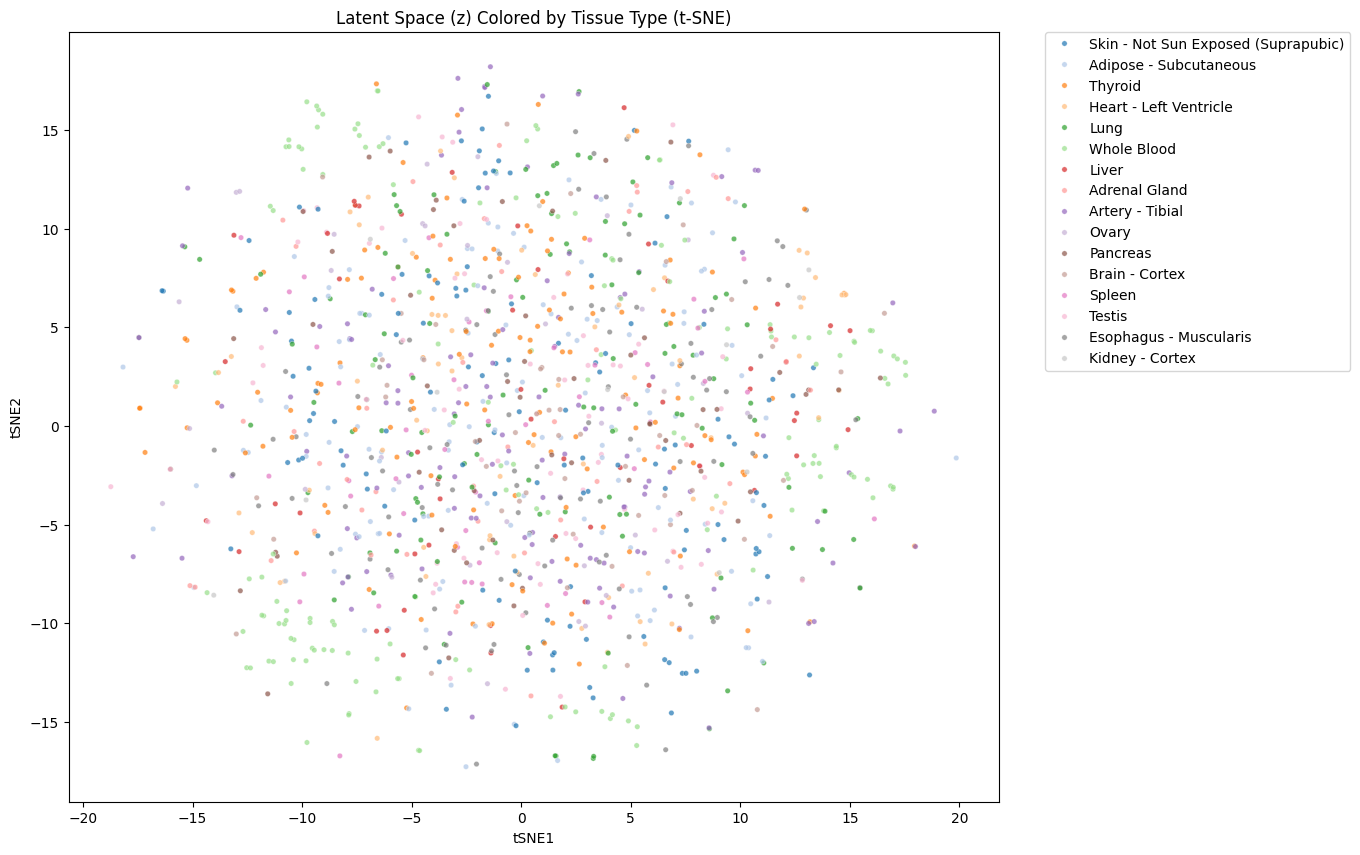


--- Counterfactual Prediction Example ---
Predicting what a Lung sample would look like if it were Liver tissue from the same person.
Source Sample: GTEX-OIZF-0526-SM-7MXVM (Lung)
Target Context: Liver tissue


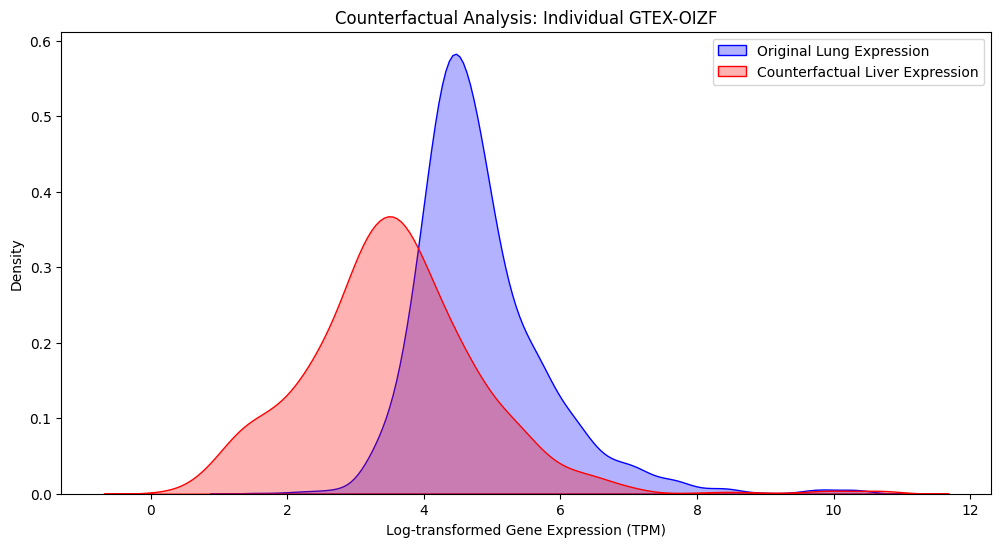


Top 5 Genes Upregulated in Counterfactual Liver vs. Lung:
                 gene_id    change
1198  ENSG00000104635.13  3.187849
731   ENSG00000130707.17  2.628484
1712  ENSG00000196136.17  2.446279
1002   ENSG00000169738.7  2.407971
1182  ENSG00000138356.13  2.220431

Top 5 Genes Downregulated in Counterfactual Liver vs. Lung:
                gene_id    change
301  ENSG00000158747.13 -4.815036
111   ENSG00000197766.7 -4.829921
59   ENSG00000152583.12 -5.050394
666  ENSG00000110799.13 -5.110138
578  ENSG00000102760.12 -6.107378

--- Project Evaluation Complete ---
This demonstrates the model's ability to reconstruct data, visualize latent space, and generate meaningful counterfactual predictions.


In [7]:
# -*- coding: utf-8 -*-
"""
Cell 6 (Counterfactual Project): Model Evaluation and Counterfactual Generation
Loads the best trained CausalContextualVAE, evaluates its performance,
visualizes the latent space, and performs a counterfactual prediction.
"""

# --- 1. Imports ---
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import pickle
import gc
from tqdm.notebook import tqdm
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# --- 2. Re-establish Environment (for standalone execution) ---
print("\n--- Re-establishing Environment and Loading Processed Data & Encoders ---")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)
np.random.seed(42)

PROJECT_ROOT = '/content/drive/My Drive/Disentangling/'
PROCESSED_DATA_DIR = os.path.join(PROJECT_ROOT, 'processed_data_counterfactual/')
ENCODERS_DIR = os.path.join(PROJECT_ROOT, 'encoders/')

# Load processed data
metadata_df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'gtex_metadata_processed_final.csv'))
gene_expression_np = np.load(os.path.join(PROCESSED_DATA_DIR, 'gtex_expression_processed_final.npy'))
gene_list = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'gtex_processed_gene_list_final.txt'), header=None).squeeze().tolist()

# Load fitted encoders/scalers
with open(os.path.join(ENCODERS_DIR, 'tissue_encoder.pkl'), 'rb') as f:
    tissue_encoder = pickle.load(f)
with open(os.path.join(ENCODERS_DIR, 'sex_encoder.pkl'), 'rb') as f:
    sex_encoder = pickle.load(f)
with open(os.path.join(ENCODERS_DIR, 'age_scaler.pkl'), 'rb') as f:
    age_scaler = pickle.load(f)
with open(os.path.join(ENCODERS_DIR, 'individual_encoder.pkl'), 'rb') as f:
    individual_encoder = pickle.load(f)

print("Successfully loaded processed data and fitted encoders/scalers.")

# Re-define global dimensions
NUM_SAMPLES = metadata_df.shape[0]
NUM_GENES = gene_expression_np.shape[1]
NUM_TISSUE_TYPES = len(tissue_encoder.classes_)
NUM_SEXES = len(sex_encoder.classes_)
NUM_INDIVIDUALS = len(individual_encoder.classes_)

# --- 3. Re-define Model and Dataset Classes (for standalone execution) ---
# This ensures the correct architecture is used for loading the saved model.
class GTExCausalVAE_Dataset(Dataset):
    def __init__(self, metadata_df, gene_expression_array,
                 tissue_encoder, sex_encoder, age_scaler, individual_encoder):
        self.metadata_df = metadata_df.copy()
        self.gene_expression = torch.tensor(gene_expression_array, dtype=torch.float32)

        self.metadata_df['tissue_id'] = tissue_encoder.transform(self.metadata_df['tissue_type'])
        self.metadata_df['sex_id'] = metadata_df['sex'] # Use numerical sex from CSV
        self.metadata_df['age_scaled'] = age_scaler.transform(self.metadata_df['age_numerical'].values.reshape(-1, 1)).flatten()
        self.metadata_df['individual_index'] = individual_encoder.transform(self.metadata_df['individual_id'])

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        row = self.metadata_df.iloc[idx]
        individual_id = torch.tensor(row['individual_index'], dtype=torch.long)
        tissue_id = torch.tensor(row['tissue_id'], dtype=torch.long)
        age_scaled = torch.tensor(row['age_scaled'], dtype=torch.float32)
        sex_id = torch.tensor(row['sex_id'], dtype=torch.long)
        gene_expression = self.gene_expression[idx]
        return individual_id, tissue_id, age_scaled, sex_id, gene_expression

class ConditionalEncoder(nn.Module):
    def __init__(self, num_genes, num_tissue_types, num_sexes, num_individuals,
                 age_dim=1, tissue_embedding_dim=64, sex_embedding_dim=16,
                 individual_embedding_dim=128, context_fusion_dim=256,
                 latent_dim=256):
        super(ConditionalEncoder, self).__init__()
        self.tissue_embedding = nn.Embedding(num_tissue_types, tissue_embedding_dim)
        self.sex_embedding = nn.Embedding(num_sexes, sex_embedding_dim)
        self.individual_embedding = nn.Embedding(num_individuals, individual_embedding_dim)
        self.age_mlp = nn.Sequential(nn.Linear(age_dim, 16), nn.LeakyReLU(0.01), nn.BatchNorm1d(16))
        fused_context_input_dim = tissue_embedding_dim + sex_embedding_dim + individual_embedding_dim + 16
        self.context_fusion_mlp = nn.Sequential(nn.Linear(fused_context_input_dim, context_fusion_dim), nn.LeakyReLU(0.01), nn.BatchNorm1d(context_fusion_dim))
        encoder_input_dim = num_genes + context_fusion_dim
        self.encoder_mlp = nn.Sequential(nn.Linear(encoder_input_dim, 1024), nn.LeakyReLU(0.01), nn.BatchNorm1d(1024), nn.Dropout(0.3), nn.Linear(1024, 512), nn.LeakyReLU(0.01), nn.BatchNorm1d(512))
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_log_var = nn.Linear(512, latent_dim)
    def forward(self, gene_expression, tissue_id, age_scaled, sex_id, individual_id):
        tissue_emb = self.tissue_embedding(tissue_id)
        sex_emb = self.sex_embedding(sex_id)
        individual_emb = self.individual_embedding(individual_id)
        age_out = self.age_mlp(age_scaled.unsqueeze(1))
        fused_context = torch.cat((tissue_emb, sex_emb, individual_emb, age_out), dim=1)
        context_vector = self.context_fusion_mlp(fused_context)
        encoder_input = torch.cat((gene_expression, context_vector), dim=1)
        hidden = self.encoder_mlp(encoder_input)
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        return mu, log_var, context_vector

class ConditionalDecoder(nn.Module):
    def __init__(self, latent_dim, num_genes, context_fusion_dim=256):
        super(ConditionalDecoder, self).__init__()
        decoder_input_dim = latent_dim + context_fusion_dim
        self.decoder_mlp = nn.Sequential(nn.Linear(decoder_input_dim, 512), nn.LeakyReLU(0.01), nn.BatchNorm1d(512), nn.Dropout(0.3), nn.Linear(512, 1024), nn.LeakyReLU(0.01), nn.BatchNorm1d(1024), nn.Linear(1024, num_genes))
    def forward(self, z, context_vector):
        decoder_input = torch.cat((z, context_vector), dim=1)
        reconstruction = self.decoder_mlp(decoder_input)
        return reconstruction

class CausalContextualVAE(nn.Module):
    def __init__(self, num_genes, num_tissue_types, num_sexes, num_individuals,
                 latent_dim=256, tissue_embedding_dim=64, sex_embedding_dim=16,
                 individual_embedding_dim=128, age_dim=1, context_fusion_dim=256):
        super(CausalContextualVAE, self).__init__()
        self.latent_dim = latent_dim
        self.context_fusion_dim = context_fusion_dim
        self.encoder = ConditionalEncoder(num_genes, num_tissue_types, num_sexes, num_individuals, age_dim, tissue_embedding_dim, sex_embedding_dim, individual_embedding_dim, context_fusion_dim, latent_dim)
        self.decoder = ConditionalDecoder(latent_dim, num_genes, context_fusion_dim)
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    def forward(self, gene_expression_input, tissue_id, age_scaled, sex_id, individual_id):
        mu, log_var, context_vector = self.encoder(gene_expression_input, tissue_id, age_scaled, sex_id, individual_id)
        z = self.reparameterize(mu, log_var)
        reconstructed_expression = self.decoder(z, context_vector)
        return reconstructed_expression, mu, log_var, z, context_vector
    def predict_counterfactual(self, gene_expression_source, individual_id_source, age_scaled_source, sex_id_source, tissue_id_source,
                               individual_id_target, age_scaled_target, sex_id_target, tissue_id_target):
        self.eval()
        with torch.no_grad():
            mu_source, _, _ = self.encoder(gene_expression_source, tissue_id_source, age_scaled_source, sex_id_source, individual_id_source)
            z_source = mu_source
            context_vector_target = self.encoder.context_fusion_mlp(torch.cat((self.encoder.tissue_embedding(tissue_id_target), self.encoder.sex_embedding(sex_id_target), self.encoder.individual_embedding(individual_id_target), self.encoder.age_mlp(age_scaled_target.unsqueeze(1))), dim=1))
            counterfactual_expression = self.decoder(z_source, context_vector_target)
            return counterfactual_expression

# --- 4. Instantiate and Load Best Model ---
PATH_TO_LOAD_MODEL = os.path.join(PROCESSED_DATA_DIR, 'best_causal_contextual_vae.pth')

model = CausalContextualVAE(
    num_genes=NUM_GENES,
    num_tissue_types=NUM_TISSUE_TYPES,
    num_sexes=NUM_SEXES,
    num_individuals=NUM_INDIVIDUALS,
    latent_dim=256, context_fusion_dim=256, tissue_embedding_dim=128,
    sex_embedding_dim=32, individual_embedding_dim=256, age_dim=1
).to(device)

try:
    model.load_state_dict(torch.load(PATH_TO_LOAD_MODEL, map_location=device))
    print(f"Successfully loaded best model from: {PATH_TO_LOAD_MODEL}")
except FileNotFoundError:
    print(f"Error: Model file not found at {PATH_TO_LOAD_MODEL}.")
    exit()
except Exception as e:
    print(f"An error occurred while loading the model: {e}")
    exit()

model.eval()

# --- 5. Evaluate Reconstruction Performance ---
print("\n--- Evaluating Reconstruction Performance on Validation Set ---")
full_dataset_eval = GTExCausalVAE_Dataset(metadata_df, gene_expression_np, tissue_encoder, sex_encoder, age_scaler, individual_encoder)
_, val_dataset = random_split(full_dataset_eval, [int(0.8 * len(full_dataset_eval)), len(full_dataset_eval) - int(0.8 * len(full_dataset_eval))])
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

all_predictions = []
all_targets = []
all_latent_z = []
all_metadata_val_list = []

with torch.no_grad():
    for batch_idx, (individual_ids, tissue_ids, age_scaleds, sex_ids, expression_data) in enumerate(tqdm(val_dataloader, desc="Evaluating Model")):
        individual_ids, tissue_ids, age_scaleds, sex_ids, expression_data = individual_ids.to(device), tissue_ids.to(device), age_scaleds.to(device), sex_ids.to(device), expression_data.to(device)
        reconstructed_expression, mu, _, z, _ = model(expression_data, tissue_ids, age_scaleds, sex_ids, individual_ids)
        all_predictions.append(reconstructed_expression.cpu().numpy())
        all_targets.append(expression_data.cpu().numpy())
        all_latent_z.append(z.cpu().numpy())
        global_indices_for_batch = val_dataloader.dataset.indices[batch_idx * 32 : (batch_idx + 1) * 32]
        all_metadata_val_list.append(metadata_df.iloc[global_indices_for_batch].copy())

all_predictions = np.vstack(all_predictions)
all_targets = np.vstack(all_targets)
all_latent_z = np.vstack(all_latent_z)
all_metadata_val_df = pd.concat(all_metadata_val_list).reset_index(drop=True)

print("\n--- Reconstruction Performance Metrics ---")
pearson_correlations = [pearsonr(all_targets[:, i], all_predictions[:, i])[0] for i in range(NUM_GENES) if np.std(all_targets[:, i]) > 1e-6 and np.std(all_predictions[:, i]) > 1e-6]
avg_pearson_correlation = np.mean(pearson_correlations)
print(f"Average Pearson Correlation Coefficient (per gene): {avg_pearson_correlation:.4f}")
r2_scores_per_gene = [r2_score(all_targets[:, i], all_predictions[:, i]) for i in range(NUM_GENES)]
avg_r2_score = np.mean(r2_scores_per_gene)
print(f"Average R-squared (per gene): {avg_r2_score:.4f}")

# --- 6. Visualize Latent Space ---
print("\n--- Visualizing Latent Space ---")
print("Applying t-SNE for visualization (this may take a while)...")
if all_latent_z.shape[0] > 5000:
    np.random.seed(42)
    sample_indices = np.random.choice(all_latent_z.shape[0], 5000, replace=False)
    latent_z_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(all_latent_z[sample_indices])
    latent_df_plot = all_metadata_val_df.iloc[sample_indices].copy().reset_index(drop=True)
else:
    latent_z_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(all_latent_z)
    latent_df_plot = all_metadata_val_df.copy().reset_index(drop=True)

latent_df_plot['tSNE1'] = latent_z_tsne[:, 0]
latent_df_plot['tSNE2'] = latent_z_tsne[:, 1]
sex_id_to_label_map = {1: 'Female', 2: 'Male'} # Based on GTEx documentation
latent_df_plot['sex_label'] = latent_df_plot['sex'].map(sex_id_to_label_map)

plt.figure(figsize=(12, 10))
sns.scatterplot(x='tSNE1', y='tSNE2', hue='tissue_type', data=latent_df_plot, palette='tab20', alpha=0.7, s=15, legend='full')
plt.title('Latent Space (z) Colored by Tissue Type (t-SNE)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# --- 7. Counterfactual Prediction Example ---
print("\n--- Counterfactual Prediction Example ---")
print("Predicting what a Lung sample would look like if it were Liver tissue from the same person.")

# Find a sample that is originally from Lung tissue
source_sample_df = all_metadata_val_df[all_metadata_val_df['tissue_type'] == 'Lung'].iloc[0]
source_sample_idx_in_val = source_sample_df.name # The index in all_metadata_val_df
print(f"Source Sample: {source_sample_df['sample_id']} (Lung)")

# Get the source data tensor
source_individual_id, source_tissue_id, source_age_scaled, source_sex_id, source_expression = val_dataset[source_sample_idx_in_val]

# Define the target context: same individual, age, sex, but different tissue (Liver)
target_tissue_name = 'Liver'
target_tissue_id = torch.tensor([tissue_encoder.transform([target_tissue_name])[0]], dtype=torch.long)
print(f"Target Context: Liver tissue")

# Prepare tensors for the model's counterfactual function
# All inputs need a batch dimension of 1
source_expression_batch = source_expression.unsqueeze(0).to(device)
individual_id_batch = source_individual_id.unsqueeze(0).to(device)
age_scaled_batch = source_age_scaled.unsqueeze(0).to(device)
sex_id_batch = source_sex_id.unsqueeze(0).to(device)
source_tissue_id_batch = source_tissue_id.unsqueeze(0).to(device)
target_tissue_id_batch = target_tissue_id.to(device)

# Generate counterfactual prediction
counterfactual_expression = model.predict_counterfactual(
    gene_expression_source=source_expression_batch,
    individual_id_source=individual_id_batch, age_scaled_source=age_scaled_batch,
    sex_id_source=sex_id_batch, tissue_id_source=source_tissue_id_batch,
    individual_id_target=individual_id_batch, # Same individual
    age_scaled_target=age_scaled_batch, # Same age
    sex_id_target=sex_id_batch, # Same sex
    tissue_id_target=target_tissue_id_batch # Target tissue
)

# Find an actual Liver sample from the same individual for comparison (if one exists)
individual_id_str = source_sample_df['individual_id']
actual_liver_sample = all_metadata_val_df[(all_metadata_val_df['individual_id'] == individual_id_str) & (all_metadata_val_df['tissue_type'] == 'Liver')]

# Visualize the results
plt.figure(figsize=(12, 6))
plt.title(f"Counterfactual Analysis: Individual {individual_id_str}")
sns.kdeplot(source_expression.numpy(), label='Original Lung Expression', color='blue', fill=True, alpha=0.3)
sns.kdeplot(counterfactual_expression.cpu().numpy().flatten(), label='Counterfactual Liver Expression', color='red', fill=True, alpha=0.3)
if not actual_liver_sample.empty:
    actual_liver_idx_in_val = actual_liver_sample.index[0]
    _, _, _, _, actual_liver_expression = val_dataset[actual_liver_idx_in_val]
    sns.kdeplot(actual_liver_expression.numpy(), label='Actual Liver Expression', color='green', fill=True, alpha=0.3)
plt.xlabel("Log-transformed Gene Expression (TPM)")
plt.ylabel("Density")
plt.legend()
plt.show()

# Calculate change in expression for top genes
source_expr_np = source_expression.numpy()
counterfactual_expr_np = counterfactual_expression.cpu().numpy().flatten()
gene_changes = counterfactual_expr_np - source_expr_np
gene_changes_df = pd.DataFrame({'gene_id': gene_list, 'change': gene_changes}).sort_values('change', ascending=False)
print("\nTop 5 Genes Upregulated in Counterfactual Liver vs. Lung:")
print(gene_changes_df.head())
print("\nTop 5 Genes Downregulated in Counterfactual Liver vs. Lung:")
print(gene_changes_df.tail())

print("\n--- Project Evaluation Complete ---")
print("This demonstrates the model's ability to reconstruct data, visualize latent space, and generate meaningful counterfactual predictions.")

Verifying that necessary variables from the previous cell exist...
All necessary variables found.

--- Searching for an actual Liver sample from the same individual ---
Source Individual ID: GTEX-OIZF
No actual Liver sample found for this individual in the validation set.


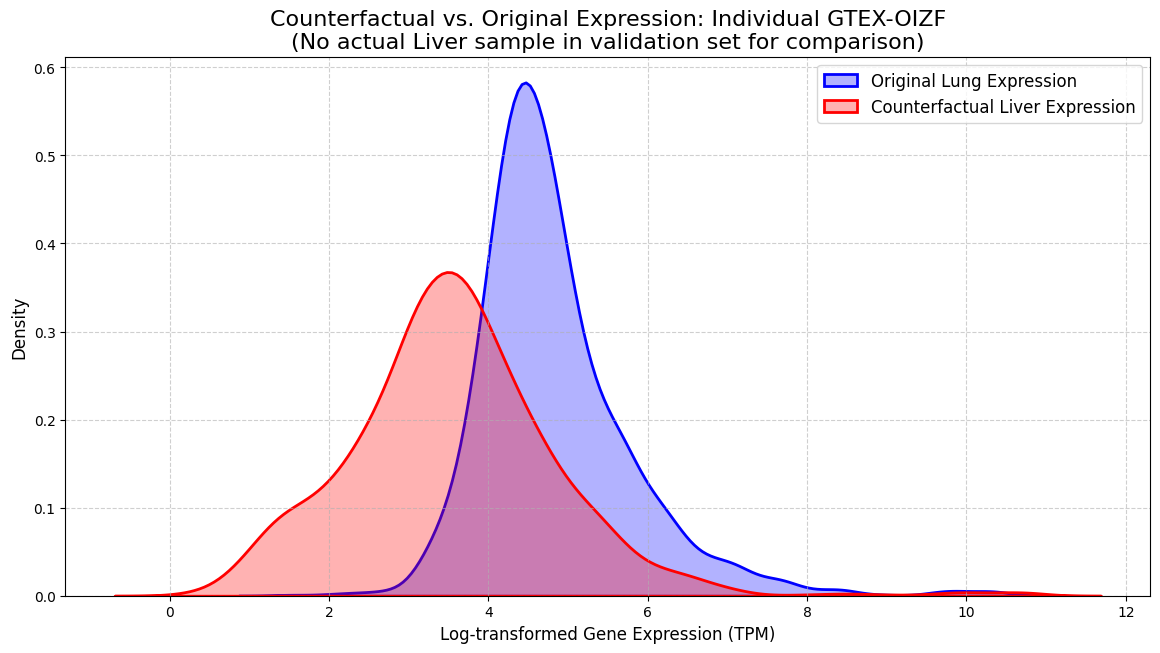

9880

In [8]:
# -*- coding: utf-8 -*-
"""
Cell 7 (Counterfactual Project): Direct Comparison of Counterfactual vs. Actual
This cell finds a real liver sample from the same individual used in the
counterfactual prediction and creates a three-way comparison plot.
"""

# --- 1. Imports ---
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# --- 2. Ensure Necessary Variables are Available ---
# This cell assumes that Cell 6 has just been run, and the following variables exist:
# - model: The trained CausalContextualVAE model
# - all_metadata_val_df: The metadata DataFrame for the validation set
# - val_dataset: The validation dataset object
# - source_sample_df: The DataFrame row for the original lung sample
# - source_expression: The tensor of the original lung sample's expression
# - counterfactual_expression: The tensor of the generated counterfactual liver expression
try:
    print("Verifying that necessary variables from the previous cell exist...")
    source_sample_df
    source_expression
    counterfactual_expression
    all_metadata_val_df
    val_dataset
    print("All necessary variables found.")
except NameError:
    print("Error: This cell must be run immediately after the previous evaluation cell (Cell 6).")
    print("Please re-run the evaluation cell to generate the necessary variables.")
    exit()

# --- 3. Find the Actual Liver Sample from the Same Individual ---
print("\n--- Searching for an actual Liver sample from the same individual ---")

# Get the individual ID from our source lung sample
source_individual_id_str = source_sample_df['individual_id']
print(f"Source Individual ID: {source_individual_id_str}")

# Search for a sample from this individual where the tissue type is 'Liver'
# We search in `all_metadata_val_df` which contains all samples from the validation set
actual_liver_sample_df = all_metadata_val_df[
    (all_metadata_val_df['individual_id'] == source_individual_id_str) &
    (all_metadata_val_df['tissue_type'] == 'Liver')
]

# --- 4. Generate the Comparison Plot ---
# This plot will show the original lung, the generated liver, and the actual liver (if found).

plt.figure(figsize=(14, 7))
plt.title(f"Counterfactual vs. Actual Gene Expression: Individual {source_individual_id_str}", fontsize=16)

# Plot 1: Original Lung Expression (Blue) - always available
sns.kdeplot(source_expression.numpy(), label='Original Lung Expression', color='blue', fill=True, alpha=0.3, linewidth=2)

# Plot 2: Counterfactual Liver Expression (Red) - always available
sns.kdeplot(counterfactual_expression.cpu().numpy().flatten(), label='Counterfactual Liver Expression', color='red', fill=True, alpha=0.3, linewidth=2)

# Plot 3: Actual Liver Expression (Green) - only if found
if not actual_liver_sample_df.empty:
    # Get the first matching liver sample if multiple exist
    actual_liver_sample_row = actual_liver_sample_df.iloc[0]
    # Get its index in the validation metadata dataframe to find it in the dataset
    actual_liver_idx_in_val_df = actual_liver_sample_row.name

    # Retrieve the full data tuple for this sample from the validation dataset
    _, _, _, _, actual_liver_expression = val_dataset[actual_liver_idx_in_val_df]

    print(f"Found actual Liver sample: {actual_liver_sample_row['sample_id']}")
    sns.kdeplot(actual_liver_expression.numpy(), label='Actual Liver Expression', color='green', fill=True, alpha=0.3, linewidth=2)
else:
    print("No actual Liver sample found for this individual in the validation set.")
    # Add a note to the plot title if no actual liver sample is found
    plt.title(f"Counterfactual vs. Original Expression: Individual {source_individual_id_str}\n(No actual Liver sample in validation set for comparison)", fontsize=16)


plt.xlabel("Log-transformed Gene Expression (TPM)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Clean up to free memory
del actual_liver_sample_df
gc.collect()

Verifying that necessary variables from previous cells exist...
All necessary variables found.

--- Step 1: Selecting Two Different Lung Samples for Comparison ---
Source Sample A: GTEX-OIZF-0526-SM-7MXVM (from Individual GTEX-OIZF)
Source Sample B: GTEX-11NSD-0326-SM-5A5LS (from Individual GTEX-11NSD)

--- Step 2: Generating Counterfactual Liver Expression for Both Samples ---
Counterfactuals generated successfully.

--- Step 3: Analyzing and Comparing the Results ---


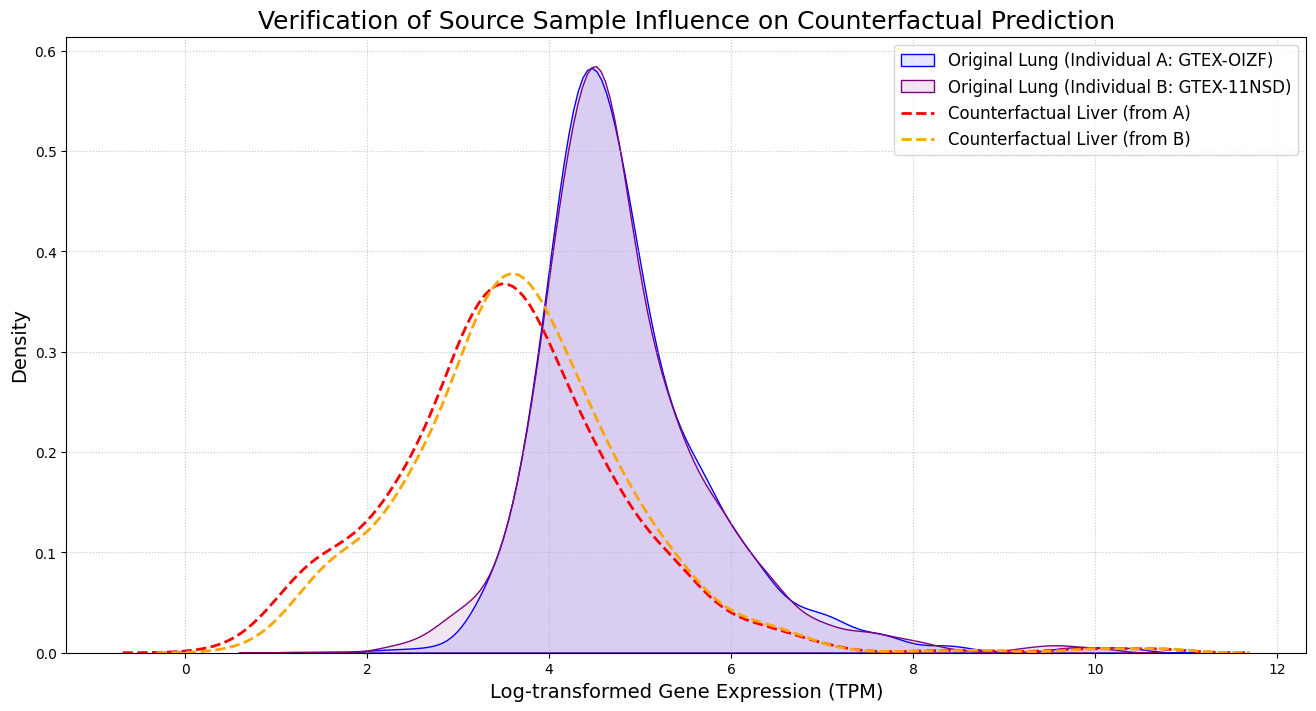


Quantitative Comparison:
Mean Squared Error (MSE) between the two counterfactual livers: 0.0260
MSE between the two original lungs: 0.1506

--- Interpretation of Results ---
✅ **Success!** The two counterfactual liver profiles are different from each other.
This strongly indicates that the model is NOT just generating a generic liver template.
Instead, it is correctly using the unique biological signature (latent space 'z') of each source lung sample and blending it with the 'liver' context.
The inherent differences between the two source individuals are preserved even after the counterfactual transformation.


7684

In [9]:
# -*- coding: utf-8 -*-
"""
Cell 8 (Counterfactual Project): Verifying the Influence of the Source Sample
This cell performs a control experiment to verify that the model's counterfactual
predictions are dependent on the source sample's unique identity (latent z),
and not just a generic template for the target context.
"""

# --- 1. Imports and Setup ---
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# --- 2. Ensure Necessary Variables are Available ---
# This cell assumes that the previous evaluation cell (Cell 6 or 7) has been run.
try:
    print("Verifying that necessary variables from previous cells exist...")
    model
    all_metadata_val_df
    val_dataset
    tissue_encoder
    source_sample_df # The first lung sample from the previous cell
    source_expression # The expression tensor for the first lung sample
    print("All necessary variables found.")
except NameError:
    print("Error: This cell must be run immediately after the previous evaluation cell.")
    print("Please re-run the evaluation cell to generate the necessary variables.")
    exit()

# --- 3. Find a Second, Different Lung Sample ---
print("\n--- Step 1: Selecting Two Different Lung Samples for Comparison ---")

# We already have our first source sample from the previous cell
source_A_df = source_sample_df
source_A_expression = source_expression
source_A_individual_id_str = source_A_df['individual_id']
print(f"Source Sample A: {source_A_df['sample_id']} (from Individual {source_A_individual_id_str})")

# Find a second lung sample from a DIFFERENT individual in the validation set
source_B_df = all_metadata_val_df[
    (all_metadata_val_df['tissue_type'] == 'Lung') &
    (all_metadata_val_df['individual_id'] != source_A_individual_id_str)
].iloc[0] # Get the first one that is not from the same person

source_B_idx_in_val = source_B_df.name
_, _, _, _, source_B_expression = val_dataset[source_B_idx_in_val]
source_B_individual_id_str = source_B_df['individual_id']
print(f"Source Sample B: {source_B_df['sample_id']} (from Individual {source_B_individual_id_str})")


# --- 4. Generate Counterfactual Liver from Both Source Samples ---
print("\n--- Step 2: Generating Counterfactual Liver Expression for Both Samples ---")

# Define the target context: Liver (same for both)
target_tissue_name = 'Liver'
target_tissue_id_tensor = torch.tensor([tissue_encoder.transform([target_tissue_name])[0]], dtype=torch.long).to(device)

# --- Generate Counterfactual A ---
source_A_idx_in_val = source_A_df.name
ind_A, tis_A, age_A, sex_A, expr_A = val_dataset[source_A_idx_in_val]
counterfactual_A = model.predict_counterfactual(
    expr_A.unsqueeze(0).to(device), ind_A.unsqueeze(0).to(device), age_A.unsqueeze(0).to(device),
    sex_A.unsqueeze(0).to(device), tis_A.unsqueeze(0).to(device),
    ind_A.unsqueeze(0).to(device), age_A.unsqueeze(0).to(device),
    sex_A.unsqueeze(0).to(device), target_tissue_id_tensor
).cpu().numpy().flatten()

# --- Generate Counterfactual B ---
ind_B, tis_B, age_B, sex_B, expr_B = val_dataset[source_B_idx_in_val]
counterfactual_B = model.predict_counterfactual(
    expr_B.unsqueeze(0).to(device), ind_B.unsqueeze(0).to(device), age_B.unsqueeze(0).to(device),
    sex_B.unsqueeze(0).to(device), tis_B.unsqueeze(0).to(device),
    ind_B.unsqueeze(0).to(device), age_B.unsqueeze(0).to(device),
    sex_B.unsqueeze(0).to(device), target_tissue_id_tensor
).cpu().numpy().flatten()

print("Counterfactuals generated successfully.")


# --- 5. Analyze and Compare the Results ---
print("\n--- Step 3: Analyzing and Comparing the Results ---")

# --- Visual Comparison ---
plt.figure(figsize=(16, 8))
plt.title("Verification of Source Sample Influence on Counterfactual Prediction", fontsize=18)

# Plot the two original lung samples
sns.kdeplot(source_A_expression.numpy(), label=f'Original Lung (Individual A: {source_A_individual_id_str})', color='blue', fill=True, alpha=0.1)
sns.kdeplot(source_B_expression.numpy(), label=f'Original Lung (Individual B: {source_B_individual_id_str})', color='purple', fill=True, alpha=0.1)

# Plot the two generated counterfactual liver samples
sns.kdeplot(counterfactual_A, label=f'Counterfactual Liver (from A)', color='red', linewidth=2, linestyle='--')
sns.kdeplot(counterfactual_B, label=f'Counterfactual Liver (from B)', color='orange', linewidth=2, linestyle='--')

plt.xlabel("Log-transformed Gene Expression (TPM)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()


# --- Quantitative Comparison ---
# Calculate the Mean Squared Error (MSE) between the two counterfactuals.
# If the model is just a template, this value should be close to zero.
mse_between_counterfactuals = np.mean((counterfactual_A - counterfactual_B)**2)
print(f"\nQuantitative Comparison:")
print(f"Mean Squared Error (MSE) between the two counterfactual livers: {mse_between_counterfactuals:.4f}")

# For context, calculate MSE between the two original lungs
mse_between_originals = np.mean((source_A_expression.numpy() - source_B_expression.numpy())**2)
print(f"MSE between the two original lungs: {mse_between_originals:.4f}")

# --- 6. Final Interpretation ---
print("\n--- Interpretation of Results ---")
if mse_between_counterfactuals > 0.01: # Using a small threshold to account for float precision
    print("✅ **Success!** The two counterfactual liver profiles are different from each other.")
    print("This strongly indicates that the model is NOT just generating a generic liver template.")
    print("Instead, it is correctly using the unique biological signature (latent space 'z') of each source lung sample and blending it with the 'liver' context.")
    print("The inherent differences between the two source individuals are preserved even after the counterfactual transformation.")
else:
    print("❌ **Model Failure Indicated.** The two counterfactual liver profiles are nearly identical.")
    print("This suggests the model might be ignoring the source sample's identity ('z') and only using the target context ('liver') to generate a generic profile.")

gc.collect()